# Computing a final Tiangong-1 pass with Python

Do you remember the thrilling re-entry scene
at the end of the movie _Gravity_?
The Chinese space station Tiangong-1
is orbiting at thousands of miles per hour
when (spoiler) it dips fatally into the Earth's upper atmosphere.
The drag buffets and tears at the station’s components
before the increasing friction
finally flashes the air around the station into a glowing plasma,
reducing the station to a shredded sparkling field of debris.

Well — tomorrow, it’s actually going to happen.

But before it does, I’d love to see Tiangong-1 from the ground
as it makes its final orbits above our planet.
Can Python help me find a final pass of Tiangong-1
over my town?

Let’s give it a try!

<!--more-->

For this simple exercise in plotting a satellite pass,
we’ll need only the pylab environment,
my own Skyfield astronomy library,
and the “pytz” time zone utility:


In [34]:
%pylab inline
pylab.rcParams['figure.figsize'] = 7, 7

from skyfield import api
from pytz import timezone
eastern = timezone('US/Eastern')

Populating the interactive namespace from numpy and matplotlib


We can have Skyfield
download the latest orbital elements for humanity’s space stations
directly from the [Celestrak](https://celestrak.com/) site:


In [2]:
sats = api.load.tle('https://celestrak.com/NORAD/elements/stations.txt')
tiangong = sats['TIANGONG 1']

And the final thing we’ll need is a time vector
that represents every minute over the two-day period
that starts as I write this blog post and ends mid-day Monday,
by which time it’s predicted (no one knows for sure)
that Tiangong-1 will have re-entered and been destroyed.

Skyfield makes it very easy to create time vectors.
Simply call the `utc()` method of Skyfield’s time scale object,
and provide an array for one of the values.
It’s okay if the values overflow —
in this case, for example, the number of minutes goes far past 59 —
because Skyfield cleanly wraps any overflow
into the following hours and days.

The resulting time object
will have as many times as there were items in the input array:


In [3]:
# Two days, starting at 2018-03-31 18:00 UTC

minutes = range(60 * 24 * 2)
ts = api.load.timescale()
t = ts.utc(2018, 3, 31, 18, minutes)
print(t)

<Time 2880 values from tt=2458209.250801 to tt=2458211.250106>


And with these raw materials ready,
we can get down to business.
Let’s compute Tiangong-1’s location relative to my town
by simple vector subtraction,
use `at()` to compute that vector at each of the times in our time array,
and then ask for the results
as altitude above (or below) the horizon
and azimuth around the horizon.


In [25]:
bluffton = api.Topos(latitude='40.8953 N', longitude='83.8888 W')
orbit = (tiangong - bluffton).at(t)
alt, az, distance = orbit.altaz()
print(alt)
print(az)

2880 values from -89deg 27' 44.4" to 71deg 09' 35.4"
2880 values from 00deg 01' 45.3" to 359deg 52' 43.7"


We now have an azimuth and an altitude angle
for each of the times in our time array.
If I want to see Tiangong-1 from my house,
I’ll need it to be above the horizon.
Let’s compute a Boolean vector that’s `True`
at each minute when Tiangong-1 has an altitude above the horizon:


In [26]:
above_horizon = alt.degrees > 0
print(above_horizon)

[False False False ... False False False]


Out of all of the hours of `False` values each day
when Tiangong-1 is below the horizon,
how are we going to find the rare `True` values
that indicate a few minutes when it’s above the horizon?
One approach would be the NumPy `nonzero()` method
to find the indices of each minute above the horizon:


In [5]:
indicies, = above_horizon.nonzero()
print(indicies)

[ 902  903  904  905  906  907  993  994  995  996  997  998  999 1085
 1086 1087 1088 1089 1090 1091 1177 1178 1179 1180 1181 1182 1269 1270
 1271 1272 1273 2303 2304 2305 2306 2307 2393 2394 2395 2396 2397 2398
 2399 2485 2486 2487 2488 2489 2490 2577 2578 2579 2580 2581 2582 2668
 2669 2670 2671 2672 2673]


Reading through the array of indices,
we can see that Tiangong-1 tends to stay above the horizon
for several minutes at a time —
for example, there’s a run of consecutive array indices
from 902 to 907, then a long gap of 86 minutes below the horizon,
then another appearance above it from 993 to 999.

Can we ask NumPy to figure out when these passes of the satellite overhead
begin and end?

We can!
There are several possible approaches,
but one of the simplest is to use NumPy’s `diff()` function
to find each place in the array
where the value stops being `False` and flips to `True`,
or where a run of `True` values ends and the values revert to `False`.


In [16]:
boundaries, = diff(above_horizon).nonzero()
print(boundaries)

[ 901  907  992  999 1084 1091 1176 1182 1268 1273 2302 2307 2392 2399
 2484 2490 2576 2582 2667 2673]


Nice!
This hands us the indices at which each pass begins and ends.
The `reshape()` method can now take those pairs of rising and setting indices
and put them next to each other in 2-item arrays.


In [28]:
passes = boundaries.reshape(len(boundaries) // 2, 2)
print(passes)

[[ 901  907]
 [ 992  999]
 [1084 1091]
 [1176 1182]
 [1268 1273]
 [2302 2307]
 [2392 2399]
 [2484 2490]
 [2576 2582]
 [2667 2673]]


For our final step,
I want a plot of each pass overhead
together with the times of rising and setting.
These will let me search for a pass that’s not during daylight,
and that’s high enough in the sky that I have a good chance of seeing it.

Here’s a routine
that it took me around a half-hour to write,
looking up matplotlib answers on Stack Overflow most of that time.
(I know, I should try out that new [Altair Declarative Visualization in Python](https://altair-viz.github.io/) project sometime soon,
but for this occasion I just grabbed matplotlib as something familiar.)
This routine prints the rising and setting time of a pass
and then annotates a quick polar plot
whose center is the sky’s zenith (the very top of the sky)
and whose outer edge is the horizon.
The radius shows the “zenith angle” down from the top of the sky,
with 90° being the horizon itself.


In [31]:
def plot_sky(pass_indices):
    i, j = pass_indices
    print('Rises:', t[i].astimezone(eastern))
    print('Sets:', t[j].astimezone(eastern))
    
    # Set up the polar plot.
    ax = plt.subplot(111, projection='polar')
    ax.set_rlim([0, 90])
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    
    # Draw line and labels.
    θ = az.radians
    r = 90 - alt.degrees
    ax.plot(θ[i:j], r[i:j], 'ro--')
    for k in range(i, j):
        text = t[k].astimezone(eastern).strftime('%H:%M')
        ax.text(θ[k], r[k], text, ha='right', va='bottom')

The first pass, alas, doesn’t look promising.
It stays far too close to the horizon:

Rises: 2018-04-01 05:01:00-04:00
Sets: 2018-04-01 05:07:00-04:00


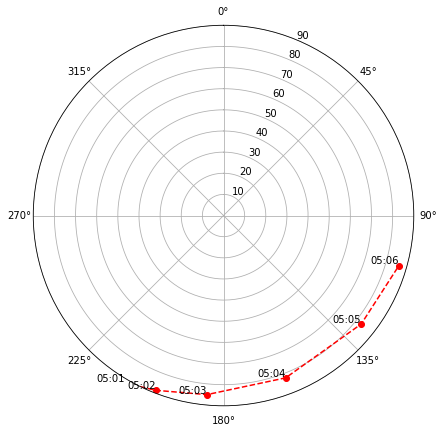

In [35]:
plot_sky(passes[0])

But the second pass is a winner!
Tiangong-1 should be high and bright
when passing so near the zenith
so close to the time of sunrise,
when the sun is likely to catch it and make it shine:


Rises: 2018-04-01 06:32:00-04:00
Sets: 2018-04-01 06:39:00-04:00


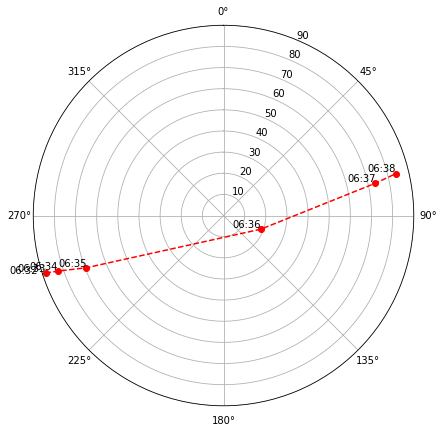

In [36]:
plot_sky(passes[1])

I investigated the further passes,
but they’re during daylight.
And as Sunday progresses and Tiangong-1 dips further into the atmosphere,
predictions based on an average atmosphere like this
will become worse and worse,
so I’d better grab this morning opportunity and not wait!

For reference,
here are the passes above my town
that the [renowned satellite tracking site Heavens Above](http://www.heavens-above.com/)
predicts:

<img src="http://rhodesmill.org/brandon/2018/heavens-above-passes.png">

As you can see,
the Python code in this post gives results quite close to theirs,
despite how primitive our methods are —
for example,
we didn’t ask NumPy to figure out the exact second in each minute
when rising and setting took place.
The difference in rise and set times could simply be that they are using different
orbital parameters than the ones I snagged from Celestrak;
differences of a minute or two are normal for satellite predictions,
which have an inherently large error.

In case you want to reproduce the above data later —
at which point Celestrak will probably either be giving
an updated orbit for the station,
or else have removed it completely following re-entry —
here are the parameters in the `stations.txt` I downloaded:

```
TIANGONG 1              
1 37820U 11053A   18090.63734353  .01995214  91302-5  18234-3 0  9994
2 37820  42.7537 203.0502 0007804 350.3894   9.7592 16.37770827373815
```

For those of you interested in astronomy and Python,
I hope this gave you a taste of how Skyfield and NumPy
can make some amateur astronomy tasks easier —
and maybe even lets you plan an observation session for Tiangong-1
or another satellite sometime.
And let’s all hope that Tiangong-1 itself, though out of human control,
falls to Earth without any harm.